In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['r/s', 'w/s', 'kr/s', 'kw/s', 'wait', 'actv', 'wsvc_t', 'asvc_t', '%w', '%b', 'device']
TEST_CONFIG = 'max-rate-submit'
DISK_CONFIG = 'ssd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['c1t1d0', 'c1t2d0', 'c1t3d0', 'c2t0d0', 'c2t1d0', 'c2t2d0',
         'c4t0d0', 'c4t1d0', 'c4t2d0', 'c3t0d0', 'c3t1d0']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'openzfs-447-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%b', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'openzfs-447-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%b', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# OpenZFS #447 Performance Results - Max Rate Submit on SSDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would issue the writes as quickly as possible; i.e. immediately after a thread's write would complete, it would issue the next write. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration

 - VM running on VMWare ESXi 6.0.0
 - 32 vCPUs
 - 512 GB of RAM
 - Enterprise Solid State Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

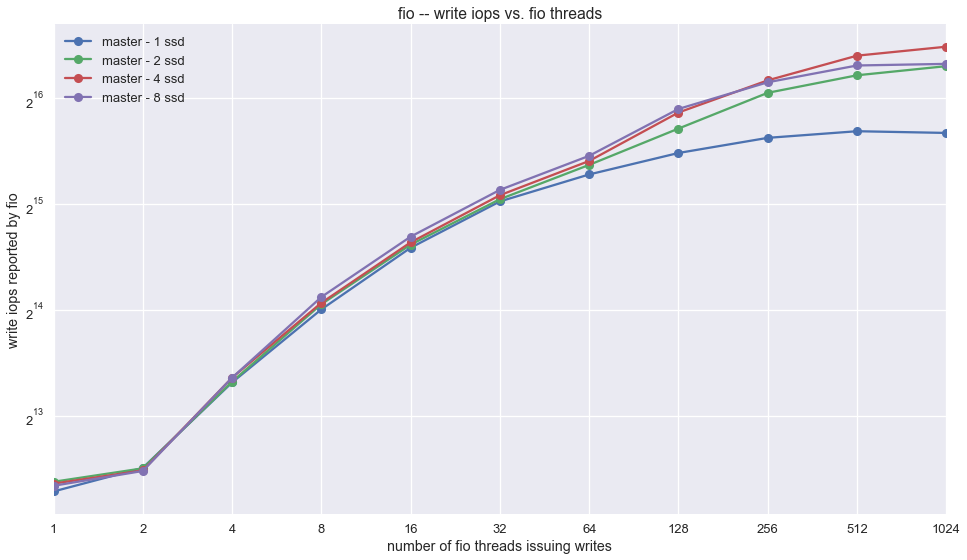

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,4979.90,5306.18,5242.85,5169.01
2,5812.49,5795.04,5716.79,5696.14
4,10175.73,10232.98,10498.49,10498.26
8,16432.53,16998.40,17152.00,17821.95
16,24615.69,25121.86,25504.92,26473.08
32,33349.12,33841.41,34738.01,35974.32
64,39807.64,42380.92,43490.18,44981.75
128,45820.27,53774.69,59745.29,61161.21
256,50601.66,67987.32,73773.76,72848.55
512,52847.91,76263.97,86735.59,81325.09


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

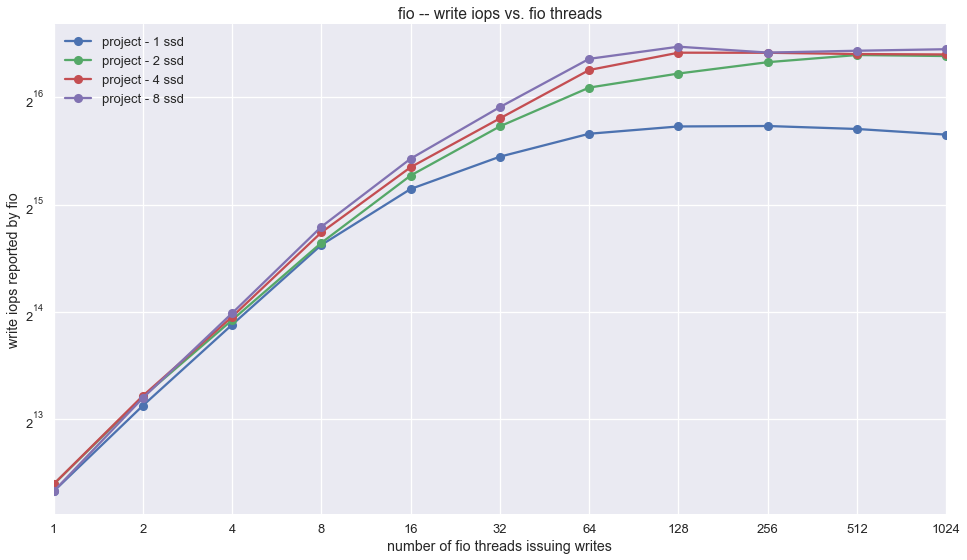

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,5124.75,5363.66,5369.33,5124.33
2,8923.62,9449.91,9506.26,9375.27
4,15062.17,15522.92,15854.07,16223.65
8,25228.51,25576.94,27360.68,28378.06
16,36228.39,39524.34,41708.62,44070.53
32,44646.89,54318.18,57197.51,61523.72
64,51784.06,69796.66,78197.09,84056.59
128,54282.25,76433.91,87459.37,90913.90
256,54437.04,82252.39,87417.77,87518.10
512,53401.44,86149.43,86694.34,88568.36


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

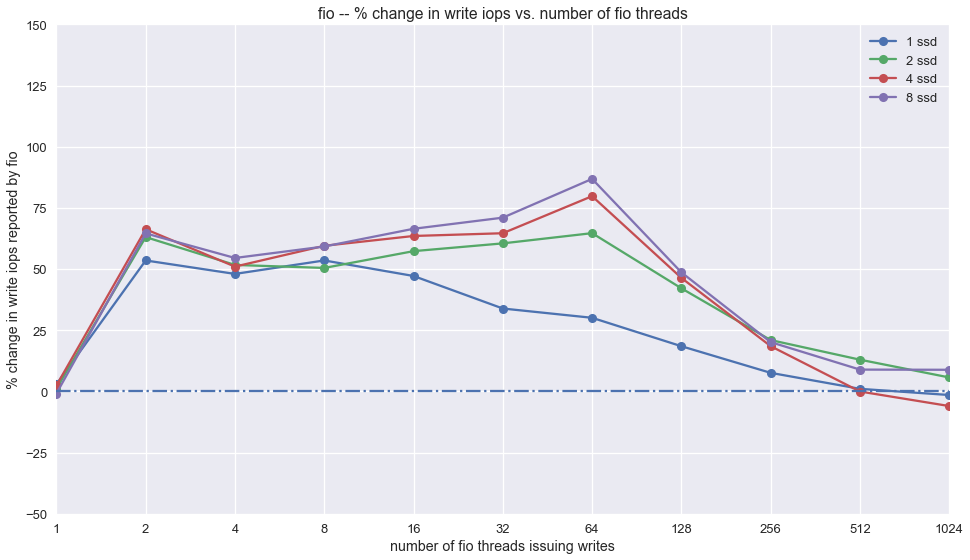

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-50, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 ssd,2 ssd,4 ssd,8 ssd
1,2.908693,1.083265,2.412428,-0.864382
2,53.524909,63.068935,66.286675,64.589880
4,48.020535,51.695010,51.012860,54.536561
8,53.527850,50.466750,59.518890,59.230948
16,47.176008,57.330468,63.531664,66.472998
32,33.877266,60.508028,64.653963,71.021217
64,30.085732,64.688874,79.804016,86.868208
128,18.467765,42.137333,46.387054,48.646340
256,7.579554,20.981957,18.494394,20.137051
512,1.047402,12.962163,-0.047558,8.906563


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

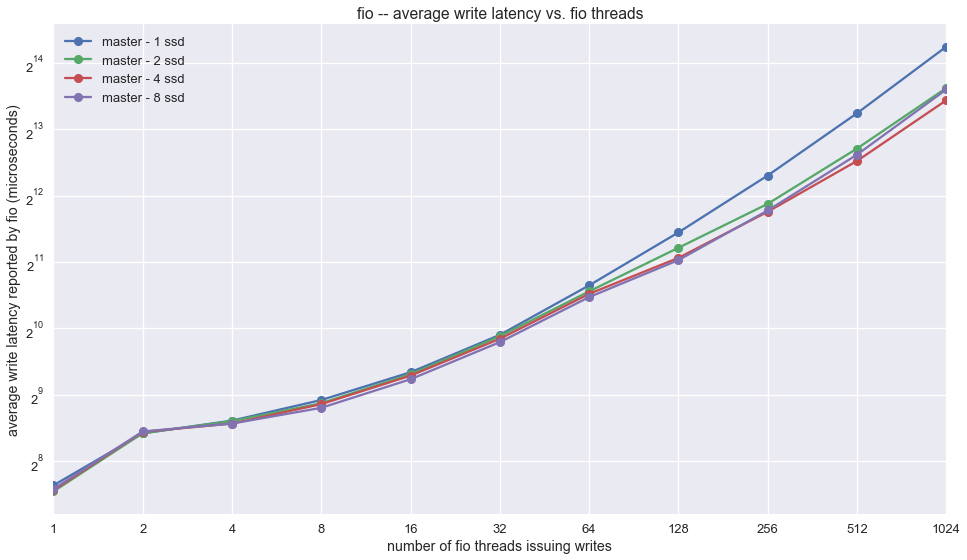

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,199.15,186.81,189.15,191.79
2,342.41,343.45,348.12,349.40
4,391.48,389.35,379.46,379.47
8,485.26,469.14,464.86,447.39
16,648.40,635.34,625.80,602.87
32,957.89,943.96,919.57,887.91
64,1605.78,1508.31,1469.77,1421.01
128,2790.93,2377.45,2139.97,2090.61
256,5054.95,3760.76,3464.02,3509.63
512,9682.48,6698.97,5885.39,6282.49


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

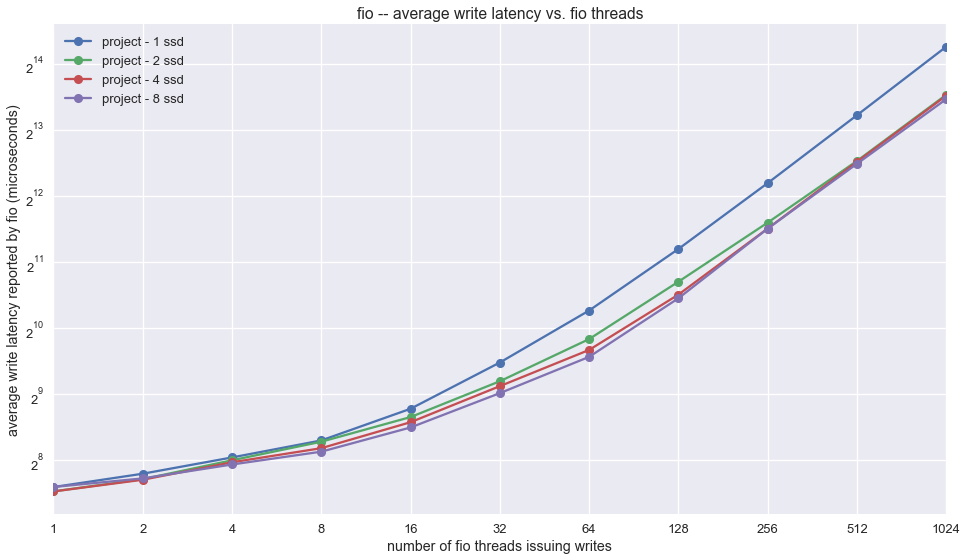

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,193.43,184.84,184.67,193.52
2,222.46,210.11,208.86,211.80
4,263.89,256.17,250.82,245.08
8,315.46,311.21,290.83,280.38
16,439.87,403.18,381.98,361.45
32,714.65,587.13,557.66,518.31
64,1233.39,913.93,815.56,758.36
128,2352.45,1668.75,1457.21,1402.24
256,4698.05,3102.50,2914.88,2913.29
512,9578.17,5926.93,5879.14,5753.45


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

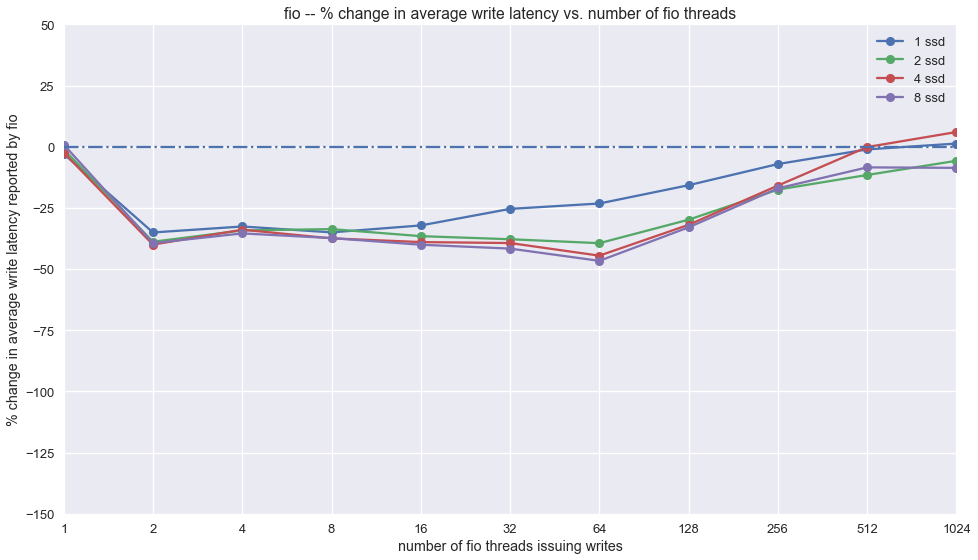

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-150, 50)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 ssd,2 ssd,4 ssd,8 ssd
1,-2.872207,-1.054547,-2.368491,0.902028
2,-35.031103,-38.823701,-40.003447,-39.381797
4,-32.591703,-34.205727,-33.900806,-35.415184
8,-34.991551,-33.663725,-37.437078,-37.329846
16,-32.160703,-36.541065,-38.961329,-40.045118
32,-25.393312,-37.801390,-39.356438,-41.625840
64,-23.190599,-39.407018,-44.511046,-46.632325
128,-15.710892,-29.809249,-31.905120,-32.926753
256,-7.060406,-17.503377,-15.852680,-16.991535
512,-1.077307,-11.524757,-0.106195,-8.420865


## `%b` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%b` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -xn 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%b` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%b` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%b` averaged across all disks in zpool vs. `fio` threads - master branch

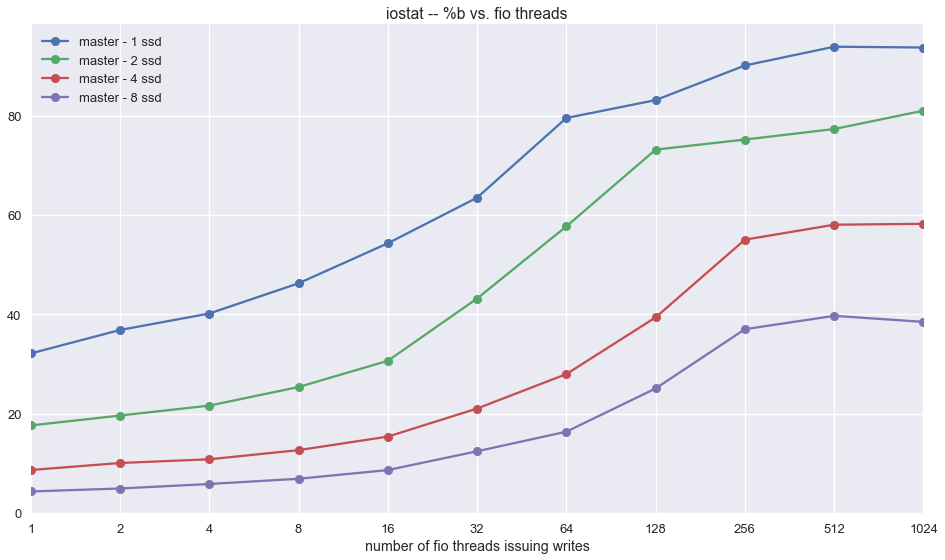

In [15]:
plot_iostat_column_dataframe(master_busy, '%b')

In [16]:
master_busy

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,32.107143,17.589286,8.607143,4.280702
2,36.839286,19.589286,10.017857,4.877193
4,40.160714,21.589286,10.767857,5.789474
8,46.250000,25.339286,12.614035,6.842105
16,54.321429,30.625000,15.339286,8.596491
32,63.517857,43.178571,21.000000,12.385965
64,79.589286,57.732143,27.947368,16.333333
128,83.196429,73.214286,39.385965,25.052632
256,90.175439,75.245614,55.052632,37.000000
512,93.965517,77.362069,58.068966,39.694915


### `%b` averaged across all disks in zpool vs. `fio` threads - project branch

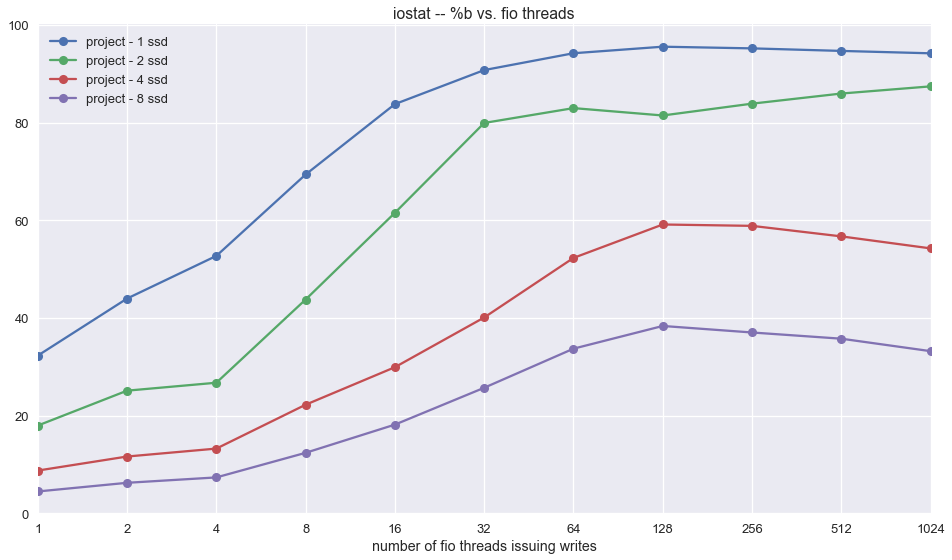

In [17]:
plot_iostat_column_dataframe(project_busy, '%b')

In [18]:
project_busy

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,32.321429,18.000000,8.785714,4.508772
2,44.000000,25.142857,11.660714,6.280702
4,52.732143,26.767857,13.285714,7.385965
8,69.392857,43.803571,22.267857,12.421053
16,83.803571,61.553571,29.947368,18.192982
32,90.767857,79.946429,40.125000,25.736842
64,94.214286,82.982143,52.315789,33.736842
128,95.553571,81.473684,59.157895,38.385965
256,95.210526,83.894737,58.877193,37.051724
512,94.689655,85.965517,56.724138,35.779661


## on-cpu, system wide, kernel flame graphs

The visualizations below are on-cpu flame-graphs of the entire system, using kernel level stacks. Unlike the line graphs above, there isn't a straightforward way to condense all of the test runs into a single flame-graph visualization. Thus, instead of showing the unique graph for each configuration, 2 configurations were specifically chosen with hopes that these two show a representative sample of the whole population. The two chosen configurations are:

 - 1 disk zpool, with 1024 `fio` threads
 - 8 disk zpool, with 1024 `fio` threads

Both configurations have the largest number of `fio` threads available; and then one configuration has the largest number of disks, and the other configuration has the least number of disks.

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - master branch

![image](max-rate-submit-master-1-ssd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 1 disk - 1024 `fio` threads - project branch

![image](max-rate-submit-project-1-ssd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - master branch

![image](max-rate-submit-master-8-ssd-fio-1024-jobs-dtrace-profile.svg)

### on-cpu, system wide, kernel flame graph - 8 disks - 1024 `fio` threads - project branch

![image](max-rate-submit-project-8-ssd-fio-1024-jobs-dtrace-profile.svg)